### Import All libraries

In [1]:
from Libraries import *

The libraries used for this notebook are:
Pandas version: 2.1.2
Numpy version: 1.24.3
Seaborn version: 0.12.2
Matplotlib version: 3.7.1
Scikitlearn version: 1.3.2
Imblearn version: 0.11.0
Scipy version: 1.11.3


### MODEL DEVELOPMENT

### Can perceived health be accurately predicted using dietary habits, socioeconomic indicators, lifestyle choices, and individual metrics?

In [2]:
%matplotlib inline

In [3]:
#Read in cleaned 2019 and 2021 Dataframes with numerical outliers removed
model_train = pd.read_csv('/Users/obinnadinneya/Desktop/MY_BIGDATA_PROJECT/mydata/MMSA2019_Cleaned_2.csv')
model_valid = pd.read_csv('/Users/obinnadinneya/Desktop/MY_BIGDATA_PROJECT/mydata/MMSA2021_Cleaned_2.csv')

In [4]:
model_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83666 entries, 0 to 83665
Data columns (total 90 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DISPCODE  83666 non-null  int64  
 1   HHADULT   83666 non-null  float64
 2   SEXVAR    83666 non-null  object 
 3   GENHLTH   83666 non-null  object 
 4   PHYSHLTH  83666 non-null  float64
 5   MENTHLTH  83666 non-null  float64
 6   _HLTHPLN  83666 non-null  object 
 7   MEDCOST1  83666 non-null  object 
 8   CHECKUP1  83666 non-null  object 
 9   CVDINFR4  83666 non-null  object 
 10  CVDCRHD4  83666 non-null  object 
 11  CVDSTRK3  83666 non-null  object 
 12  ASTHMA3   83666 non-null  object 
 13  CHCSCNCR  83666 non-null  object 
 14  CHCOCNCR  83666 non-null  object 
 15  ADDEPEV3  83666 non-null  object 
 16  CHCKDNY2  83666 non-null  object 
 17  DIABETE4  83666 non-null  object 
 18  MARITAL   83666 non-null  object 
 19  EDUCA     83666 non-null  object 
 20  RENTHOM1  83666 non-null  ob

In [5]:
model_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104617 entries, 0 to 104616
Data columns (total 90 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   DISPCODE  104617 non-null  int64  
 1   HHADULT   104617 non-null  float64
 2   SEXVAR    104617 non-null  object 
 3   GENHLTH   104617 non-null  object 
 4   PHYSHLTH  104617 non-null  float64
 5   MENTHLTH  104617 non-null  float64
 6   _HLTHPLN  104617 non-null  object 
 7   MEDCOST1  104617 non-null  object 
 8   CHECKUP1  104617 non-null  object 
 9   CVDINFR4  104617 non-null  object 
 10  CVDCRHD4  104617 non-null  object 
 11  CVDSTRK3  104617 non-null  object 
 12  ASTHMA3   104617 non-null  object 
 13  CHCSCNCR  104617 non-null  object 
 14  CHCOCNCR  104617 non-null  object 
 15  ADDEPEV3  104617 non-null  object 
 16  CHCKDNY2  104617 non-null  object 
 17  DIABETE4  104617 non-null  object 
 18  MARITAL   104617 non-null  object 
 19  EDUCA     104617 non-null  object 
 20  RENT

### Link to Data dictionary
[Data Dictionary](https://github.com/OBINNADINNEYA/MY_BIGDATA_PROJECT/tree/branch_1/Questionnaires%20and%20Calculated%20variables%20(Data%20Dictionary))

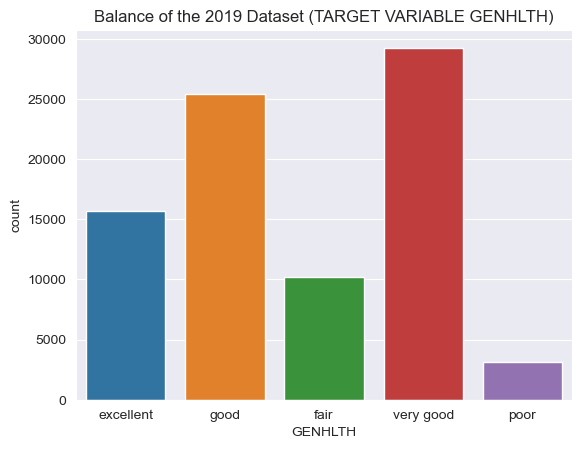

In [6]:
#Balance of the Dataset (TARGET VARIABLE GENHLTH)
sns.set_style('darkgrid')
sns.countplot(x=model_train['GENHLTH'])
plt.title('Balance of the 2019 Dataset (TARGET VARIABLE GENHLTH)')
plt.show()

In [7]:
model_train['GENHLTH'].value_counts()

GENHLTH
very good    29279
good         25396
excellent    15695
fair         10190
poor          3106
Name: count, dtype: int64

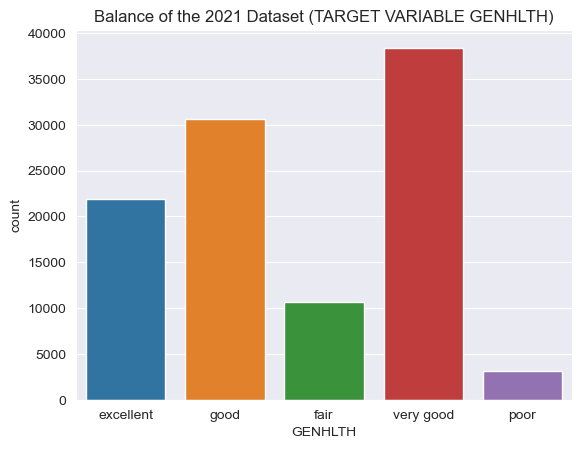

In [8]:
#Balance of the Dataset (TARGET VARIABLE _RFHLTH)
sns.set_style('darkgrid')
sns.countplot(x=model_valid['GENHLTH'])
plt.title('Balance of the 2021 Dataset (TARGET VARIABLE GENHLTH)')
plt.show()

NB: Both Datasets are highly Imbalanced

We can see that the ratio of those who percieve their health to be good vs those who do not is 7:1 an indication of a highly imbalanced Dataset. We can apply SMOTE technique to introduced randomn samples of the lower class in order to balance out the samples for model training.

In [9]:
#Creating a new data frame with only dummmy categorical data and num columns in order 
#for models to accepts inputs without erros 
num_cols = list(model_train.select_dtypes(exclude='object').columns)
cat_cols = list(model_train.select_dtypes(include='object').columns)

dummies_df = model_train[num_cols]
cat_cols = list(cat_cols)

for i in ['GENHLTH','_RFHLTH']:
    cat_cols.remove(i)


for i in cat_cols:
    temp = pd.get_dummies(model_train[i], drop_first=True, prefix=i)
    dummies_df = pd.concat([dummies_df, temp.astype(int)], axis=1)

dummies_df.shape

(83666, 198)

In [10]:
dummies_df.columns = dummies_df.columns.astype(str)
model_train.columns = model_train.columns.astype(str)

In [11]:
#2019 dataset
X = dummies_df
y = model_train['GENHLTH']

## BASE MODELS

### Base Decision Tree Model

- **Grid Search:** Utilized to fine-tune model hyperparameters ensuring optimal complexity and preventing overfitting.
- **SMOTE Application:** SMOTE is applied exclusively to the training set to address class imbalance, creating synthetic samples to present the model with a balanced class representation during training.
- **Stratified K-Fold Cross-Validation:** Ensures each fold has a representative ratio of the target classes, improving model evaluation and maintaining robustness against class imbalance.

> **Note:** Stratified K-Fold is critical for imbalanced datasets to ensure that performance metrics reflect a model's true predictive power without bias introduced by uneven class distribution across folds.



In [12]:
#1) Base Decision Tree Model

# Splitting the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#SMOTE was included in the pipeline as it has been shown to produce accuracy 
#closer to that in the test accuracy result
pipeline = IMBPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Parameter grid:
#limiting the max_depth of the tree to prevent overfitting
param_grid = {
    'classifier__max_depth': [None,10, 20],  
    'classifier__min_samples_split': [2, 10], 
    'classifier__min_samples_leaf': [1, 5]  
}

# Cross-validation setup
# Speak to the hyperparameters
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  

# GridSearch setup

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring = 'accuracy',
    cv=stratified_kfold,
    n_jobs=-1
)

#start timing the training 
start_time = time.time()

# Fitting the model on the training data
grid_search.fit(X_train, y_train)

# End timing the training process
end_time = time.time()

# Calculate the training time
training_time_dtree = end_time - start_time

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")
base_dtree_pipeline = grid_search.best_estimator_


#Retrieve the accuracy for each of the 5 folds of cross-validation
best_params_index = grid_search.best_index_
base_tree_cv_folds_scores = grid_search.cv_results_['split0_test_score'][best_params_index], \
                  grid_search.cv_results_['split1_test_score'][best_params_index], \
                  grid_search.cv_results_['split2_test_score'][best_params_index], \
                  grid_search.cv_results_['split3_test_score'][best_params_index], \
                  grid_search.cv_results_['split4_test_score'][best_params_index]

print(f"Accuracy for each fold using best parameters: {base_tree_cv_folds_scores}")


#start timing the test process  
start_time = time.time()

# Making predictions on the test set
predictions = base_dtree_pipeline.predict(X_test)

# End timing the test process
end_time = time.time()

# Calculate the training time
testing_time_dtree = end_time - start_time

# Calculate the MCC
mcc = matthews_corrcoef(y_test, predictions)

print(f'Matthews Correlation Coefficient: {mcc}')
print('---------------------------------------')

# Print classification report and confusion matrix for the test data
print("\nClassification Report (Test Data):\n", classification_report(y_test, predictions))
print('---------------------------------------')
print("Confusion Matrix (Test Data):\n", confusion_matrix(y_test, predictions))
print('---------------------------------------')
print(f"Training time: {training_time_dtree} seconds")
print(f"Testing time: {testing_time_dtree} seconds")


Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10}
Best score: 0.42248858921058785
Accuracy for each fold using best parameters: (0.42384402778815267, 0.41488010756704263, 0.42424921559838635, 0.4276109367996414, 0.42185865829971614)
Matthews Correlation Coefficient: 0.2294862063848256
---------------------------------------

Classification Report (Test Data):
               precision    recall  f1-score   support

   excellent       0.39      0.45      0.42      3125
        fair       0.39      0.33      0.35      2061
        good       0.43      0.39      0.41      5028
        poor       0.39      0.52      0.45       635
   very good       0.47      0.49      0.48      5885

    accuracy                           0.43     16734
   macro avg       0.42      0.43      0.42     16734
weighted avg       0.43      0.43      0.43     16734

---------------------------------------
Confusion Matrix (Test Data):
 [[1392  

-------

In [13]:
#2) Base Logistic Regression 

    #By scaling features before feeding them into a logistic regression model, 
    #you help the model to treat all features fairly, speed up the training process, 
    #and make the output (coefficients) more interpretable.
    # Implementing a pipeline with cross-validation ensures proper scaling practices.
    # Each cross-validation fold scales its data separately, avoiding the mistake of using
    # the entire dataset's information for scaling. This prevents data leakage —
    # a situation where information from outside the training dataset influences the model.
    # Consequently, each validation step is conducted on data scaled within its own fold,
    # maintaining the integrity of the process and leading to a more accurate evaluation
    # of the model's performance.
    
    #Model Pipieline is prepared solely on the training set to avoid data leakage


# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Creating a logistic regression model instance
logreg_model = LogisticRegression(max_iter=10000)

# Creating a pipeline with SMOTE and Logistic Regression:
pipeline = IMBPipeline([
    ('scaler', RobustScaler()),
    ('smote', SMOTE()),
    ('logreg', logreg_model)
])

# Defining the parameter grid
param_grid = {
    'logreg__C': [0.01, 0.1, 1],
    'logreg__solver': ['lbfgs']
}

# GridSearchCV setup
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1)

#start timing the training 
start_time = time.time()

# Fitting GridSearchCV
grid_search.fit(X_train, y_train)

# End timing the training process
end_time = time.time()

# Calculate the training time
training_timelogreg = end_time - start_time

# Best parameters and estimator
print("Best Parameters:", grid_search.best_params_)
print(f"Best score: {grid_search.best_score_}")
base_logreg_pipeline = grid_search.best_estimator_


#Retrieve the accuracy for each of the 5 folds of cross-validation
best_params_index = grid_search.best_index_
base_logreg_cv_folds_scores = grid_search.cv_results_['split0_test_score'][best_params_index], \
                  grid_search.cv_results_['split1_test_score'][best_params_index], \
                  grid_search.cv_results_['split2_test_score'][best_params_index], \
                  grid_search.cv_results_['split3_test_score'][best_params_index], \
                  grid_search.cv_results_['split4_test_score'][best_params_index]
print(f"Accuracy for each fold using best parameters: {base_logreg_cv_folds_scores}")

#start timing the testing process
start_time = time.time()

# Predictions and evaluation using the best estimator
y_pred = base_logreg_pipeline.predict(X_test)

# End timing the testing process
end_time = time.time()

# Calculate the testing time
testing_timelogreg = end_time - start_time


# Calculate the MCC
mcc = matthews_corrcoef(y_test, y_pred)

print(f'Matthews Correlation Coefficient: {mcc}')
print('---------------------------------------')

print("Classification Report:\n", classification_report(y_test, y_pred))
print('---------------------------------------')
print("Confusion Matrix (Test Data):\n", confusion_matrix(y_test, y_pred))
print('---------------------------------------')
print(f"Training time: {training_timelogreg} seconds")
print(f"Testing time: {testing_timelogreg} seconds")

Best Parameters: {'logreg__C': 0.01, 'logreg__solver': 'lbfgs'}
Best score: 0.4267614547992961
Accuracy for each fold using best parameters: (0.425338014491671, 0.4304922686188093, 0.426191543403556, 0.4265650679814732, 0.4252203795009712)
Matthews Correlation Coefficient: 0.2596036299174699
---------------------------------------
Classification Report:
               precision    recall  f1-score   support

   excellent       0.38      0.63      0.47      3125
        fair       0.36      0.41      0.38      2061
        good       0.46      0.35      0.40      5028
        poor       0.35      0.74      0.47       635
   very good       0.52      0.35      0.42      5885

    accuracy                           0.43     16734
   macro avg       0.41      0.50      0.43     16734
weighted avg       0.45      0.43      0.42     16734

---------------------------------------
Confusion Matrix (Test Data):
 [[1981  100  352   16  676]
 [ 101  853  444  556  107]
 [ 900 1001 1746  242 1139]

----

In [14]:
#3) Base Randomn forest Model

# Splitting the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Pipeline with SMOTE and Random Forest classifier
#Model Pipieline is prepared solely on the training set to avoid data leakage

pipeline = IMBPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', rf_classifier)
])

# Parameter grid for Random Forest classifier including the default parameters, to get the best parameters 
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# StratifiedKFold to maintain the class distribution within each fold for accurate representation of dataset
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV for hyperparameter tuning and cross-validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=stratified_kfold,
    n_jobs=-1  
)


#start timing the training 
start_time = time.time()

# Fitting the model on the training data
grid_search.fit(X_train, y_train)

#end timing the training 
end_time = time.time()

# Calculate the training time
training_timerf = end_time - start_time

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")
base_rfc_pipeline = grid_search.best_estimator_


#Retrieve the accuracy for each of the 5 folds of cross-validation
best_params_index = grid_search.best_index_
base_rfc_cv_folds_scores = grid_search.cv_results_['split0_test_score'][best_params_index], \
                  grid_search.cv_results_['split1_test_score'][best_params_index], \
                  grid_search.cv_results_['split2_test_score'][best_params_index], \
                  grid_search.cv_results_['split3_test_score'][best_params_index], \
                  grid_search.cv_results_['split4_test_score'][best_params_index]
print(f"Accuracy for each fold using best parameters: {base_rfc_cv_folds_scores}")

#start timing the testing 
start_time = time.time()

# Making predictions on the test set
predictions = base_rfc_pipeline.predict(X_test)

#end timing the testing
end_time = time.time()

# Calculate the testing time
testing_timerf = end_time - start_time

# Calculate the MCC
mcc = matthews_corrcoef(y_test, predictions)

print(f'Matthews Correlation Coefficient: {mcc}')
print('---------------------------------------')

# Print classification report and confusion matrix for the test data
print("\nClassification Report (Test Data):\n", classification_report(y_test, predictions))
print('---------------------------------------')
print("Confusion Matrix (Test Data):\n", confusion_matrix(y_test, predictions))
print('---------------------------------------')
print(f"Training time: {training_timerf} seconds")
print(f"Testing time: {testing_timerf} seconds")


Best parameters: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best score: 0.46742971708304826
Accuracy for each fold using best parameters: (0.46858892955852693, 0.460446702024352, 0.4713880173315404, 0.47101449275362317, 0.46571044374719855)
Matthews Correlation Coefficient: 0.26972955568192086
---------------------------------------

Classification Report (Test Data):
               precision    recall  f1-score   support

   excellent       0.46      0.36      0.40      3125
        fair       0.42      0.36      0.39      2061
        good       0.46      0.47      0.46      5028
        poor       0.43      0.50      0.47       635
   very good       0.50      0.57      0.53      5885

    accuracy                           0.47     16734
   macro avg       0.46      0.45      0.45     16734
weighted avg       0.47      0.47      0.47     16734

---------------------------------------
Confusio

---

## Models with Feature Selection

We will be using the built in feature selector from the randomn forrest:
For our transformation, I've chosen the RobustScaler for numeric features and the OHE for categorical features. 

In [15]:
#Using 2019 datasets 
#1 split the data
X = model_train.drop(columns=['_RFHLTH','GENHLTH'])
y = model_train['GENHLTH']

#1 Split the data into 20% test and 80% training to ensure more data for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [16]:
#2 Define the lambda function with default arguments to avoid passing arguments later
def selector(X_train, dtype_include=None, dtype_exclude=None):
    """
    Selects columns from the DataFrame `X_train` based on specified inclusion or exclusion data types.

    Parameters:
    X_train (DataFrame): The DataFrame to select columns from.
    dtype_include (list, optional): A list of data types to include. Defaults to None.
    dtype_exclude (list, optional): A list of data types to exclude. Defaults to None.

    Returns:
    list: A list of column names that meet the specified criteria.
    """
    selected_columns = []
    for col in X_train.columns:
        if ((dtype_include is None) or (X_train[col].dtype in dtype_include)) and \
           ((dtype_exclude is None) or (X_train[col].dtype not in dtype_exclude)):
            selected_columns.append(col)
    
    return selected_columns

In [17]:
#2 Used the selector to define the columns for the ColumnTransformer
column_trans = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), selector(X_train,dtype_exclude=["object"])),
        ('cat', OneHotEncoder(), selector(X_train, dtype_include=["object"]))
    ],
    remainder='drop'
)

# Create the Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=0)

# Create a pipeline that first transforms the data and then fits the classifier
pipeline = Pipeline(steps=[('preprocessor', column_trans),
                           ('classifier', random_forest)])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Get the feature importances
feature_importances = pipeline.named_steps['classifier'].feature_importances_

# Feature importances can be mapped back to the original features plus the created dummy variables
# You'll need to do some processing to match the feature importances with the correct feature names
# This is because after one-hot encoding, the number of features changes
# Here's an example of how to match feature importances with feature names:
onehot_columns = list(pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out())
numeric_features = list(X_train.select_dtypes(exclude=['object']).columns)
all_features = numeric_features + onehot_columns

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importances
})

# Sort the DataFrame to see which features have the most importance
feature_importances_df.sort_values(by='Importance', ascending=False, inplace=True)


In [18]:
feature_importances_df.head(30)

,Feature,Importance
10,_BMI5,0.033486
26,_MMSAWT,0.029102
20,_VEGESU1,0.027943
6,WEIGHT2,0.026461
8,_STSTR,0.026348
25,_MMSA,0.025975
9,_AGE80,0.024778
19,_FRUTSU1,0.023566
2,PHYSHLTH,0.022389
7,HEIGHT3,0.021189


In [19]:
#Create the new dummy df without dropping the first column incase it is of importance
#Therfore the shape should change
num_cols = list(model_train.select_dtypes(exclude='object').columns)
cat_cols = list(model_train.select_dtypes(include='object').columns)

dummies_df2 = model_train[num_cols]
cat_cols = list(cat_cols)

for i in ['GENHLTH','_RFHLTH']:
    cat_cols.remove(i)


for i in cat_cols:
    temp = pd.get_dummies(model_train[i], drop_first=False, prefix=i)
    dummies_df2 = pd.concat([dummies_df2, temp.astype(int)], axis=1)

dummies_df2.shape

(83666, 258)

In [20]:
#Prepare the data for the models to run using selected x important columns from dummies_df2
#get_ximp_feat is a function defined in Libraries.py
#Function for getting x import

def get_ximp_feat(x=30):
    """function for getting the x number of importance features
    """
    return list(feature_importances_df['Feature'][:x])

X = dummies_df2[get_ximp_feat(x=30)]
y = model_train['GENHLTH']

In [21]:
#1) Decision Tree Model With Selected features

# Splitting the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#SMOTE was included in the pipeline as it has been shown to produce accuracy closer to that
#in the test accuracy result
#Model Pipieline is prepared solely on the training set to avoid data leakage
pipeline = IMBPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Parameter grid:
#limiting the max_depth of the tree to prevent overfitting
param_grid = {
    'classifier__max_depth': [None,10, 20],  
    'classifier__min_samples_split': [2, 10], 
    'classifier__min_samples_leaf': [1, 5]  
}

# Cross-validation setup
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  

# GridSearch setup using accuracy as our metric and inputing the stratified cross validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy', 
    cv=stratified_kfold,
    n_jobs=-1
)

#start timing the training 
start_time = time.time()

# Fitting the model on the training data
grid_search.fit(X_train, y_train)

# End timing the training process
end_time = time.time()

# Calculate the training time
training_time_dtree2 = end_time - start_time

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")
dtree_pipeline = grid_search.best_estimator_

#Retrieve the accuracy for each fold of cross-validation
best_params_index = grid_search.best_index_
dtree_cv_folds_scores = grid_search.cv_results_['split0_test_score'][best_params_index], \
                  grid_search.cv_results_['split1_test_score'][best_params_index], \
                  grid_search.cv_results_['split2_test_score'][best_params_index], \
                  grid_search.cv_results_['split3_test_score'][best_params_index], \
                  grid_search.cv_results_['split4_test_score'][best_params_index]
print(f"Accuracy for each fold using best parameters: {dtree_cv_folds_scores}")

#start timing the testing 
start_time = time.time()

# Making predictions on the test set
predictions = dtree_pipeline.predict(X_test)

# End testing the training process
end_time = time.time()

# Calculate the training time
testing_time_dtree2 = end_time - start_time

# Calculate the MCC
mcc = matthews_corrcoef(y_test, predictions)
print('---------------------------------------')

print(f'Matthews Correlation Coefficient: {mcc}')
# Print classification report and confusion matrix for the test data
print("\nClassification Report (Test Data):\n", classification_report(y_test, predictions))
print('---------------------------------------')
print("Confusion Matrix (Test Data):\n", confusion_matrix(y_test, predictions))
print('---------------------------------------')
print(f"Training time: {training_time_dtree2} seconds")
print(f"Testing time: {testing_time_dtree2} seconds")

Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best score: 0.41025220752272185
Accuracy for each fold using best parameters: (0.40838126540673786, 0.4113692388137746, 0.4174510682802928, 0.41125056028686685, 0.40280890482593756)
---------------------------------------
Matthews Correlation Coefficient: 0.21031233098166383

Classification Report (Test Data):
               precision    recall  f1-score   support

   excellent       0.36      0.53      0.43      3125
        fair       0.37      0.34      0.36      2061
        good       0.41      0.36      0.38      5028
        poor       0.39      0.51      0.44       635
   very good       0.46      0.40      0.43      5885

    accuracy                           0.41     16734
   macro avg       0.40      0.43      0.41     16734
weighted avg       0.41      0.41      0.41     16734

---------------------------------------
Confusion Matrix (Test Data):
 [[1641   

In [22]:
#2) Logistic Regression with Selected features

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Creating a logistic regression model instance
logreg_model = LogisticRegression(max_iter=10000)

# Creating a pipeline with StandardScaler, SMOTE, and Logistic Regression:
#NB: see Note above on scaling and inputing smote and scaler in pipeline before CV to avoid overfitting and data
#leakage
#Model Pipieline is prepared solely on the training set to avoid data leakage

pipeline = IMBPipeline([
    ('scaler', RobustScaler()),
    ('smote', SMOTE(random_state=42)),
    ('logreg', logreg_model)
])

# Defining the parameter grid to compare parameters for estimators
param_grid = {
    'logreg__C': [0.01, 0.1, 1],
    'logreg__solver': ['lbfgs']
}

# GridSearchCV setup
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

#start timing the training 
start_time = time.time()

# Fitting GridSearchCV
grid_search.fit(X_train, y_train)

#end timing the training 
end_time = time.time()

# Calculate the training time
training_timelogreg2 = end_time - start_time


# Best parameters and estimator
print("Best Parameters:", grid_search.best_params_)
logreg_pipeline = grid_search.best_estimator_



#Retrieve the accuracy for each fold of cross-validation
best_params_index = grid_search.best_index_
logreg_cv_folds_scores = grid_search.cv_results_['split0_test_score'][best_params_index], \
                  grid_search.cv_results_['split1_test_score'][best_params_index], \
                  grid_search.cv_results_['split2_test_score'][best_params_index], \
                  grid_search.cv_results_['split3_test_score'][best_params_index], \
                  grid_search.cv_results_['split4_test_score'][best_params_index]
print(f"Accuracy for each fold using best parameters: {logreg_cv_folds_scores}")

#start timing the testing 
start_time = time.time()

# Predictions and evaluation using the best estimator
y_pred = logreg_pipeline.predict(X_test)

#end timing the testing
end_time = time.time()

# Calculate the testing time
testing_timelogreg2 = end_time - start_time


# Calculate the MCC
mcc = matthews_corrcoef(y_test, y_pred)
print('---------------------------------------')

print(f'Matthews Correlation Coefficient: {mcc}')
print("Classification Report:\n", classification_report(y_test, y_pred))
print('---------------------------------------')
print("Confusion Matrix (Test Data):\n", confusion_matrix(y_test, y_pred))
print('---------------------------------------')
print(f"Training time: {training_timelogreg2} seconds")
print(f"Testing time: {testing_timelogreg2} seconds")

Best Parameters: {'logreg__C': 0.01, 'logreg__solver': 'lbfgs'}
Accuracy for each fold using best parameters: (0.3962052737730634, 0.39680286845447077, 0.3913790527416704, 0.3905572986702525, 0.39578664276109365)
---------------------------------------
Matthews Correlation Coefficient: 0.2197145379214298
Classification Report:
               precision    recall  f1-score   support

   excellent       0.35      0.63      0.45      3125
        fair       0.32      0.36      0.34      2061
        good       0.43      0.32      0.36      5028
        poor       0.33      0.75      0.45       635
   very good       0.49      0.29      0.36      5885

    accuracy                           0.39     16734
   macro avg       0.38      0.47      0.39     16734
weighted avg       0.42      0.39      0.38     16734

---------------------------------------
Confusion Matrix (Test Data):
 [[1981   97  377   28  642]
 [ 130  751  451  602  127]
 [1109 1050 1594  281  994]
 [   3  118   29  477    8

In [23]:
#3) Randomn forrest Model with Selected features

# Splitting the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Pipeline with SMOTE and Random Forest classifier
pipeline = IMBPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', rf_classifier)
])

# Parameter grid for Random Forest classifier including the default parameters, to get the best parameters 
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# StratifiedKFold to maintain the class distribution within each fold for accurate representation of dataset
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV for hyperparameter tuning and cross-validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=stratified_kfold,
    n_jobs=-1  
)


#start timing the training
start_time = time.time()

# Fitting the model on the training data Only to avoid any data leakage
grid_search.fit(X_train, y_train)

#end timing the training
end_time = time.time()

# Calculate the training time
training_timerf2 = end_time - start_time

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")
rfc_pipeline = grid_search.best_estimator_

#Retrieve the accuracy for each fold of cross-validation
best_params_index = grid_search.best_index_
rfc_cv_folds_scores = grid_search.cv_results_['split0_test_score'][best_params_index], \
                  grid_search.cv_results_['split1_test_score'][best_params_index], \
                  grid_search.cv_results_['split2_test_score'][best_params_index], \
                  grid_search.cv_results_['split3_test_score'][best_params_index], \
                  grid_search.cv_results_['split4_test_score'][best_params_index]
print(f"Accuracy for each fold using best parameters: {rfc_cv_folds_scores}")

#start timing the testing
start_time = time.time()

# Making predictions on the test set
predictions = rfc_pipeline.predict(X_test)

#end timing the testing
end_time = time.time()

# Calculate the testing time
testing_timerf2 = end_time - start_time

# Calculate the MCC
mcc = matthews_corrcoef(y_test, predictions)

print(f'Matthews Correlation Coefficient: {mcc}')
print('---------------------------------------')

#Print classification report and confusion matrix for the test data
print("\nClassification Report (Test Data):\n", classification_report(y_test, predictions))
print('---------------------------------------')
print("Confusion Matrix (Test Data):\n", confusion_matrix(y_test, predictions))
print('---------------------------------------')
print(f"Training time: {training_timerf2} seconds")
print(f"Testing time: {testing_timerf2} seconds")

Best parameters: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best score: 0.44283758655811967
Accuracy for each fold using best parameters: (0.44087547620826173, 0.4394561888399193, 0.4471836246825041, 0.44673539518900346, 0.43993724787090993)
Matthews Correlation Coefficient: 0.23797975159095466
---------------------------------------

Classification Report (Test Data):
               precision    recall  f1-score   support

   excellent       0.40      0.42      0.41      3125
        fair       0.41      0.37      0.39      2061
        good       0.43      0.41      0.42      5028
        poor       0.44      0.52      0.48       635
   very good       0.47      0.50      0.48      5885

    accuracy                           0.44     16734
   macro avg       0.43      0.44      0.44     16734
weighted avg       0.44      0.44      0.44     16734

---------------------------------------
Confusi

---

### WILCOXON RANKED SIGN STATISTICAL TEST

In [24]:
#Each test will be between the baseline and feature-selected model of the same type 

# Perform the Wilcoxon signed-rank test
dtree_wilcoxon = wilcoxon(base_tree_cv_folds_scores, dtree_cv_folds_scores)
rfc_wilcoxon = wilcoxon(base_rfc_cv_folds_scores, rfc_cv_folds_scores)
logreg_wilcoxon = wilcoxon(base_logreg_cv_folds_scores, logreg_cv_folds_scores)

# Print the test statistics and p-values
print('Decision Tree Wilcoxon Test:', dtree_wilcoxon)
print('Random Forest Wilcoxon Test:', rfc_wilcoxon)
print('Logistic Regression Wilcoxon Test:', logreg_wilcoxon)


Decision Tree Wilcoxon Test: WilcoxonResult(statistic=0.0, pvalue=0.0625)
Random Forest Wilcoxon Test: WilcoxonResult(statistic=0.0, pvalue=0.0625)
Logistic Regression Wilcoxon Test: WilcoxonResult(statistic=0.0, pvalue=0.0625)


### Analysis of the Wilcoxon Signed-Rank Test

For the comparison of baseline models versus feature-selected models, the Wilcoxon signed-rank test was employed for each pair due to the non-parametric nature of the data and the small sample size of the cross-validation folds.

#### Hypotheses:

- **Null Hypotheses (H₀)**:
  1. There is no difference in the mean ranks of accuracy scores between the baseline Decision Tree and the feature-selected Decision Tree.
  2. There is no difference in the mean ranks of accuracy scores between the baseline Random Forest and the feature-selected Random Forest.
  3. There is no difference in the mean ranks of accuracy scores between the baseline Logistic Regression and the feature-selected Logistic Regression.

- **Alternative Hypotheses (H₁)**:
  1. There is a difference in the mean ranks of accuracy scores between the baseline Decision Tree and the feature-selected Decision Tree.
  2. There is a difference in the mean ranks of accuracy scores between the baseline Random Forest and the feature-selected Random Forest.
  3. There is a difference in the mean ranks of accuracy scores between the baseline Logistic Regression and the feature-selected Logistic Regression.

#### Confidence Interval: 95%

#### Test Results:

- **Decision Tree Comparison**:
  - p-value = 0.0625
  - Since the p-value is greater than 0.05, we fail to reject the null hypothesis. This suggests that there is not a statistically significant difference in mean ranks of accuracy scores between the baseline and feature-selected Decision Tree at the 95% confidence level.

- **Random Forest Comparison**:
  - p-value = 0.0625
  - As with the Decision Tree comparison, the p-value is greater than 0.05, leading us to fail to reject the null hypothesis. There is not a statistically significant difference in mean ranks of accuracy scores between the baseline and feature-selected Random Forest at the 95% confidence level.

- **Logistic Regression Comparison**:
  - p-value = 0.0625
  - The p-value greatly exceeds the 0.05 threshold, indicating a strong likelihood that we fail to reject the null hypothesis. There is no statistically significant difference in mean ranks of accuracy scores between the baseline and feature-selected Logistic Regression models.

Based on these results, none of the feature-selected models demonstrated a statistically significant improvement over the baseline models in terms of accuracy scores using the Wilcoxon signed-rank test at the 95% confidence level.


In [25]:
#Efficiency of each model 

model_efficiency = pd.DataFrame({'Training time(sec)': [training_time_dtree,training_timelogreg,training_timerf,
                                                       training_time_dtree2,training_timelogreg2,training_timerf2],
                                'Testing time(sec)': [testing_time_dtree,testing_timelogreg,testing_timerf,
                                                     testing_time_dtree2,testing_timelogreg2,testing_timerf2]},
                                index = ['base decision tree','base logistic regression', 'base random forrest', 
                                         'decision tree','logistic regression','random forrest' ] )

model_efficiency

,Training time(sec),Testing time(sec)
base decision tree,259.162987,0.017994
base logistic regression,1143.112119,0.046509
base random forrest,1692.521633,1.059127
decision tree,83.759269,0.007905
logistic regression,115.522168,0.011925
random forrest,1476.500551,1.072337


#### Model Pipeline Efficiency
The fasted model to be trained and test is the logistic regression with selected features 

---

### SELECTION OF THE BEST MODEL FOR VALIDATION ON THE 2021 DATASET

### Model Selection Based on Recall for Fair or Bad Health and Overall Accuracy

To address the public health objective of accurately identifying individuals with bad percieved health, the primary focus is on maximizing recall for the 'fair or poor health' class without significantly compromising the overall accuracy. Recall for the 'fair or poor health' class is crucial as it measures the model's ability to correctly identify all relevant instances of poor health outcomes.

#### Recall Definition:
Recall is the ratio of correctly predicted positive observations to all actual positives. High recall for the 'bad health' class indicates fewer false negatives, i.e., fewer individuals with bad health being misclassified as having good health.

#### Models Evaluated:

- **Base Decision Tree**
  - Recall for 'fair or poor health': 54%
  - Overall Accuracy: 87%
  
- **Selected features Decision Tree**
  - Recall for 'fair or poor health': 55%
  - Overall Accuracy: 87%

- **Base Random Forest**
  - Recall for 'fair or poor health': 51%
  - Overall Accuracy: 88%
  
- **Selected features Random Forest**
  - Recall for 'fair or poor health': 58%
  - Overall Accuracy: 88%

- **Base Logistic Regression**
  - Recall for 'fair or poor health': 79%
  - Overall Accuracy: 84%
  
- **Selected Features Logistic Regression**
  - Recall for 'fair or poor health': 76%
  - Overall Accuracy: 83%

#### Model Selection:

Given these performances, our chosen model is:

#### Selected Model:

The **Base Logistic Regression** is selected due to its highest recall rate for 'fair or poor health' at 79%, having an overall accuracy of 84%. This model strikes the best balance between accurately identifying cases of fair or poor health and maintaining a high level of overall accuracy.


In [26]:
#Note Data leakage was avoided by using two seprate datasets for 
#training and evaluation of models before validating selected model

import joblib

# Save the best_pipeline to disk
filename = 'finalized_model.sav'
joblib.dump(base_logreg_pipeline, filename)

['finalized_model.sav']

In [27]:
#Creating a new data frame with only dummmy categorical data and num columns in order 
#for models to accepts inputs without errors
#model_valid is the 2021 cleaned dataset

num_cols = list(model_valid.select_dtypes(exclude='object').columns)
cat_cols = list(model_valid.select_dtypes(include='object').columns)

dummies_df3 = model_valid[num_cols]
cat_cols = list(cat_cols)

for i in ['GENHLTH','_RFHLTH']:
    cat_cols.remove(i)


for i in cat_cols:
    temp = pd.get_dummies(model_valid[i], drop_first=True, prefix=i)
    dummies_df3 = pd.concat([dummies_df3, temp.astype(int)], axis=1)
    
dummies_df3.shape

(104617, 197)

In [28]:
#Check what columns are missing in the 2021 dataset
columns_not_in_df = dummies_df.columns.difference(dummies_df3.columns)
columns_not_in_df

Index(['STATE_Florida'], dtype='object')

In [29]:
#The state of florida is missing in 2021 Dataset, let us include this column STATE_Florida in new dummie df

train_columns = dummies_df.columns

dummies_df3 = dummies_df3.reindex(columns=train_columns, fill_value=0)

dummies_df3.shape

(104617, 198)

In [30]:
dummies_df3.columns = dummies_df.columns.astype(str)
model_valid.columns = model_valid.columns.astype(str)

In [31]:
#2021 dataset
X_2021 = dummies_df3
y_2021 = model_valid['GENHLTH']

In [32]:
#Load the model from disk to make new predictions
loaded_model = joblib.load(filename)

In [33]:
new_data = X_2021
new_predictions = loaded_model.predict(new_data)

# Calculate the MCC
mcc = matthews_corrcoef(y_2021, new_predictions)

print(f'Matthews Correlation Coefficient: {mcc}')
print("Accuracy:", accuracy_score(y_2021, new_predictions))
print('---------------------------------------')
# Print classification report and confusion matrix for the test data
print("\nClassification Report (Test Data):\n", classification_report(y_2021, new_predictions))
print('---------------------------------------')
print("Confusion Matrix (Test Data):\n", confusion_matrix(y_2021, new_predictions))

Matthews Correlation Coefficient: 0.2514567120226943
Accuracy: 0.43228156035825915
---------------------------------------

Classification Report (Test Data):
               precision    recall  f1-score   support

   excellent       0.41      0.62      0.49     21903
        fair       0.34      0.39      0.36     10608
        good       0.45      0.37      0.41     30601
        poor       0.34      0.74      0.46      3101
   very good       0.51      0.36      0.42     38404

    accuracy                           0.43    104617
   macro avg       0.41      0.50      0.43    104617
weighted avg       0.45      0.43      0.43    104617

---------------------------------------
Confusion Matrix (Test Data):
 [[13516   564  2673   114  5036]
 [  441  4121  2655  2722   669]
 [ 5260  5077 11439  1267  7558]
 [   32   620   138  2287    24]
 [13902  1833  8425   383 13861]]


In [34]:
#modify below

### Limitations of Using Brfss Data for predictions: 

The Behavioral Risk Factor Surveillance System (BRFSS) is a United States health-related telephone survey that collects state data about U.S. residents regarding their health-related risk behaviors, chronic health conditions, and use of preventive services. While the BRFSS is a rich data source for making health-related predictions, it has several limitations:

Self-Reported Data: BRFSS relies on individuals' self-reporting, which can lead to recall bias, under-reporting or over-reporting of behaviors or conditions due to social desirability or memory issues.

Cross-Sectional Design: BRFSS is a cross-sectional survey, which captures a snapshot in time and cannot establish causality or account for changes over time in individuals' behaviors or health status.

Telephone Survey Limitations: The survey is conducted by telephone (landline and cell phone), which may exclude populations without access to phones or those who are less likely to participate in telephone surveys, like younger individuals who primarily use messaging apps.

Sampling Errors: Despite efforts to have a representative sample, there can be sampling errors, especially if response rates are low or if certain groups are underrepresented in the sample.

Non-Response Bias: The survey is subject to non-response bias; those who choose to respond may differ systematically from those who do not.

---

In [35]:
#modify below

## Conclusion: Ensuring Efficacy in Health Predictions

By prioritizing high recall for detecting 'fair or poor health', our predictive model plays a pivotal role in patient safety and the provision of timely medical interventions. Minimizing false negatives is not just about accuracy; it's about the real-world impact on individuals who might otherwise be overlooked by the healthcare system.

In parallel, our model's precision in identifying 'Good or Better Health' allows for a more nuanced, holistic approach to health management. This aspect of the model is crucial for designing proactive health interventions, promoting wellness, and optimizing resource allocation across the healthcare spectrum.

The model's dual capability ensures that while we are vigilant in our efforts to support those in immediate need, we also empower those in 'Good or Better Health' to maintain and enhance their wellbeing. Such a holistic strategy enriches our healthcare system, fostering a preventive culture that benefits all strata of the population.

In summary, this approach establishes a healthcare environment that is preventive, responsive, and equitable, demonstrating a commitment to comprehensive care and well-being for every individual, irrespective of their current health status.
